### Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
# import powerlaw
import seaborn as sns

from collections import Counter
from random import shuffle
from scipy.stats import linregress
from typing import Final

### Define constants and read data

In [2]:
SENT_BEG: Final = '<s>'
SENT_END: Final = '</s>'
    
atw_title: Final = 'Around The World in Eighty Days'
ttl_title: Final = 'Twenty Thousand Leagues Under the Sea'
cob_title: Final = 'Combined Texts'

In [3]:
def read_from_pickle(filepath):
    """Read an object from a pickle file
    Parameters:
        filepath (str): path to the pickle file
    Returns:
        Any: the object in the file"""
    
    obj = None
    
    with open(filepath, 'rb') as pckl:
        obj = pickle.load(pckl)
        
    return obj

In [4]:
ttl_sents = read_from_pickle('./Pickles/ttl_sents.pickle')
ttl_counts = read_from_pickle('./Pickles/ttl_counts.pickle')

atw_sents = read_from_pickle('./Pickles/atw_sents.pickle')
atw_counts = read_from_pickle('./Pickles/atw_counts.pickle')

In [5]:
cob_sents = []
cob_sents.extend(ttl_sents)
cob_sents.extend(atw_sents)
shuffle(cob_sents)

len(cob_sents)

9463

### Sentence Metrics

In [6]:
def sentence_metrics(sentences: list, name, minus = 2) -> None:
    """Get sentence metrics, and plot them
    Parameters:
        sentences (list): a list of tokens in each sentence
        name (str): the name of the text
        minus (int): number of words to ignore per sentence (default: 2 i.e. <s> and </s>)
    Returns:
        None"""
    
    words = []
    
    for sentence in sentences:
        words.append(len(sentence) - minus)
        
    words = pd.Series(words)
        
    print('Number of sentences:', len(sentences))
    print('Mean length of a sentence:', np.mean(words))
    print('Median length of a sentence:', np.median(words))
    print('Max sentence length:', words.max())
    print('Min sentence length:', words.min())
    
    fig = plt.figure(figsize = (12, 8))
    plt.plot(range(1, len(sentences) + 1), words, alpha = 0.5, color = '#00788c', label = 'Number of words')
    plt.plot(range(1, len(sentences) + 1), words.rolling(100).mean(), color = '#552583', label = '100-sentence rolling avg.')
    plt.title('Sentence Lengths: {}'.format(name))
    plt.xlabel('Sentence')
    plt.ylabel('Number of Words')
    plt.legend()
    plt.show()
    plt.close()
    
#     plt.hist(words, bins = 40, density = True, log = True, color = '#00788c')
    sns.displot(words, kind = 'kde', color = '#552583')
#     plt.yscale('log')
    plt.title('Words per Sentence KDE: {}'.format(name))
    plt.xlabel('Words')
    plt.ylabel('')
    plt.show()
    plt.close()

Number of sentences: 6587
Mean length of a sentence: 15.815090329436769
Median length of a sentence: 14.0
Max sentence length: 181
Min sentence length: 1


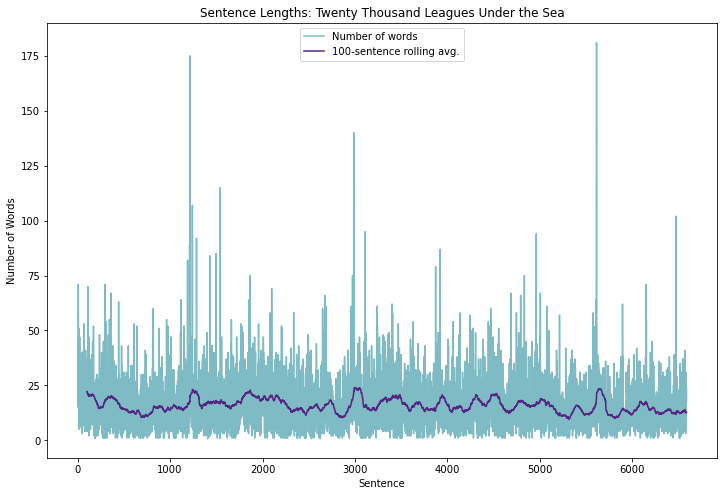

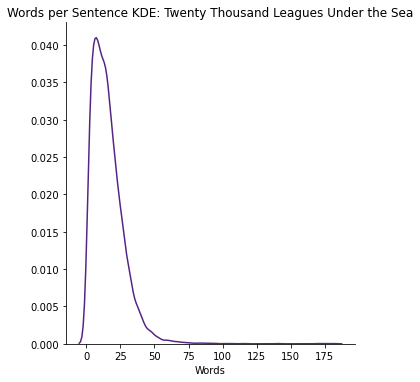

In [7]:
sentence_metrics(ttl_sents, ttl_title)

Number of sentences: 2876
Mean length of a sentence: 22.374826147426983
Median length of a sentence: 20.0
Max sentence length: 176
Min sentence length: 0


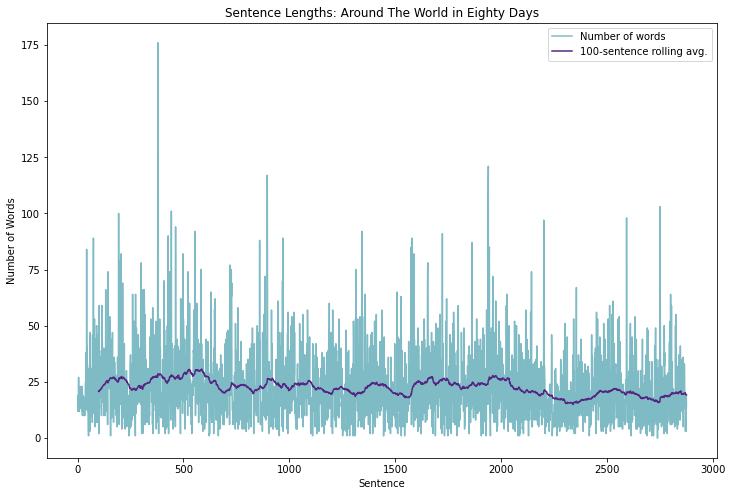

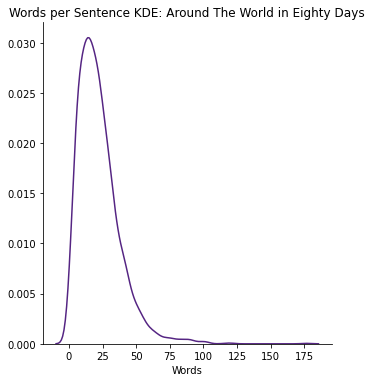

In [8]:
sentence_metrics(atw_sents, atw_title)

### Vocabulary Stats

In [9]:
def check_word(word) -> bool:
    """Check if a word is in a 'blacklist'
    Parameters:
        word (str): the word to check
    Returns:
        bool: whether of not the word is in the list"""
    
    if word in [SENT_BEG, SENT_END]:
        return True
    
    return False

In [10]:
def heaps_law(sentences: list, name) -> None:
    """Plot Heaps' Law for a list of sentences
    Parameters:
        sentences (list): a list of tokens in each sentence
        name (str): the name of the text
    Returns:
        None"""
    
    vocab, vocab_growth = set(), []
    word_count = 0
    
    for sentence in sentences:
        for word in sentence:
            
            # if word is not in the blacklist
            if not check_word(word):
                word_count += 1
                
                # if the word is unseen, add 1 to the growth count and add the word to the vocab
                if word not in vocab:
                    vocab.add(word)
                    vocab_growth.append(1)
                    
                # if the word has been seen, add 0 to the growth count
                else:
                    vocab_growth.append(0)
                    
    vocab_growth = pd.Series(vocab_growth)
    
    print('|V| = K * N ^ B i.e. log|V| = logK + BlogN')
    print('Vocab size |V|:', len(vocab))
    print('Word Count N:', word_count)
    
    x = np.array([i for i in range(1, word_count + 1)])
    vocab_growth_cumsum = vocab_growth.cumsum()
    
    # get slope and intercept from observations
    res = linregress(x = np.log10(x), y = np.log10(vocab_growth_cumsum))
    print('Predicted K:', 10 ** res.intercept)
    print('Predicted B:', res.slope)
    
    pred = (res.slope * np.log10(x)) + res.intercept  # calculated predicted |V|
    
    fig = plt.figure(figsize = (12, 8))
    plt.plot(x, vocab_growth_cumsum, color = '#552583', label = 'Observed')
    plt.plot(x, 10 ** pred, color = '#00788c', ls = '--', label = 'Predicted')
    plt.title("Heaps' Law: {}".format(name))
    plt.xlabel('Total Words Seen N')
    plt.ylabel('Vocabulary Size |V|')
    plt.legend()
    plt.show()
    plt.close()
    
    fig = plt.figure(figsize = (12, 8))
    plt.plot(np.log10(x), np.log10(vocab_growth_cumsum), color = '#552583', label = 'Observed')
    plt.plot(np.log10(x), pred, color = '#00788c', ls = '--', label = 'Predicted')
#     plt.xscale('log')
#     plt.yscale('log')
    plt.title("Heaps' Law (Log Scale): {}".format(name))
    plt.xlabel('Log Total Words Seen N')
    plt.ylabel('Log Vocabulary Size |V|')
    plt.legend()
    plt.show()
    plt.close()

|V| = K * N ^ B i.e. log|V| = logK + BlogN
Vocab size |V|: 8668
Word Count N: 104174
Predicted K: 7.533291243226517
Predicted B: 0.6172358549580007


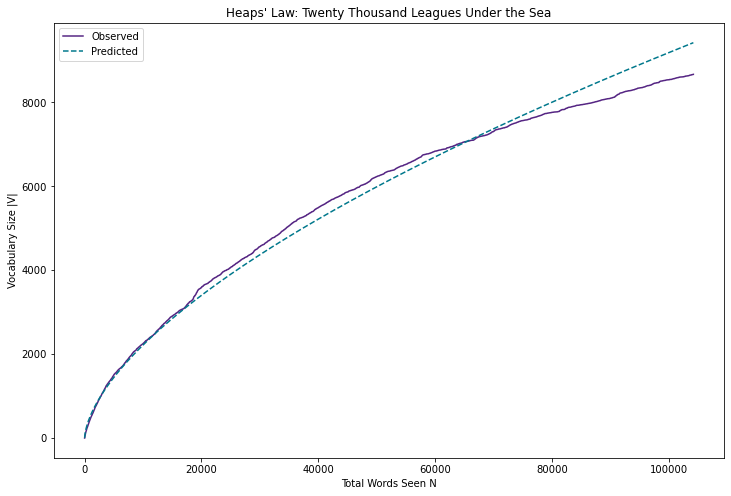

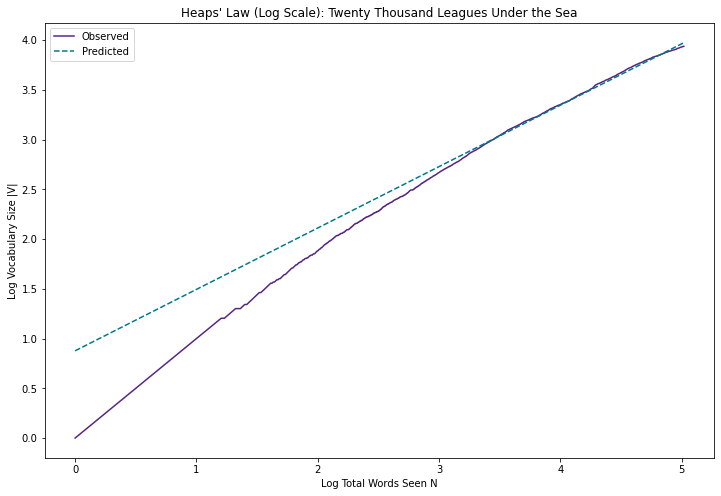

In [11]:
heaps_law(ttl_sents, ttl_title)

In [12]:
# heaps_law(atw_sents, atw_title)

In [13]:
# heaps_law(cob_sents, cob_title)

In [18]:
def zipfs_law(counts: Counter, name) -> None:
    """Plot Zipf's Law for a document
    Parameters:
        counts (Counter): token counts for the document
        name (str): the name of the text
    Returns:
        None"""
    
    freqs = np.array([wc[1] for wc in counts.most_common() if not check_word(wc[0])])
#     N = sum(freqs)
    
    print('F = K * R ^ -A i.e. logF = log K - AlogR')
    
    x = np.array([i for i in range(1, len(freqs) + 1)])
    
#     get slope and intercept from observations
    res = linregress(x = np.log10(x), y = np.log10(freqs))
    print('Predicted K:', 10 ** res.intercept)
    print('Predicted A:', res.slope)
    
    pred = (res.slope * np.log10(x)) + res.intercept  # calculated predicted F
    
    fig = plt.figure(figsize = (12, 8))
    plt.plot(np.log10(x), np.log10(freqs), color = '#552583', label = 'Observed')
    plt.plot(np.log10(x), pred, color = '#00788c', ls = '--', label = 'Predicted')
#     plt.xscale('log')
#     plt.yscale('log')
    plt.title("Zipf's Law: {}".format(name))
    plt.xlabel('Log Rank R')
    plt.ylabel('Log Frequency F')
    plt.legend()
    plt.show()
    plt.close()

F = K * R ^ -A i.e. logF = log K - AlogR
Predicted K: 38350.00857521534
Predicted A: -1.1886399270478594


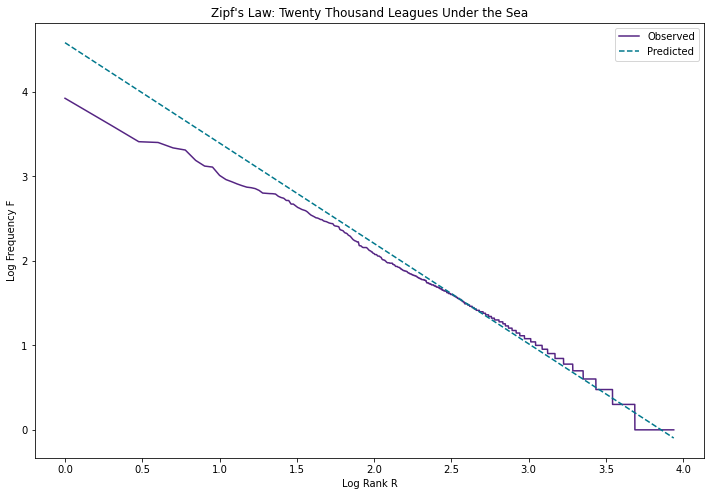

In [19]:
zipfs_law(ttl_counts, ttl_title)

F = K * R ^ -A i.e. logF = log K - AlogR
Predicted K: 15367.345632713721
Predicted A: -1.1196199859101177


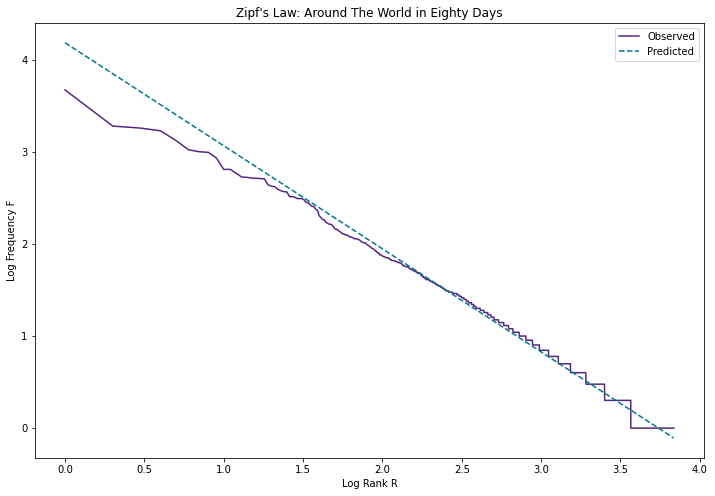

In [20]:
zipfs_law(atw_counts, atw_title)